In [15]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from IPython.display import display, clear_output

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing+BAO
######################################################

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)
print(As)

standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.66
}

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True
fsize=16

######################################################
#  Configuring the run
######################################################

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["omega_b"],
                   'omega_cdm':standard_params["omega_cdm"],
                   'ln10^{10}A_s': standard_params["ln10^{10}A_s"],
                   'n_s':standard_params["n_s"],
                   'tau_reio': standard_params["tau_reio"],
                   'thermodynamics_verbose': 0,
                   'input_verbose': 1,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                  }
precision_settings = {"start_sources_at_tau_c_over_tau_h": 0.004}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)
print(Class.__file__)

2.105209331337507e-09
/Users/gabe/.local/lib/python3.9/site-packages/classy-3.1.0-py3.9-macosx-10.9-x86_64.egg/classy.cpython-39-darwin.so


In [16]:
M.compute()

Reading input parameters
 -> matched budget equations by adjusting Omega_Lambda = 0.690267


# Standard $X_e(z)$ 

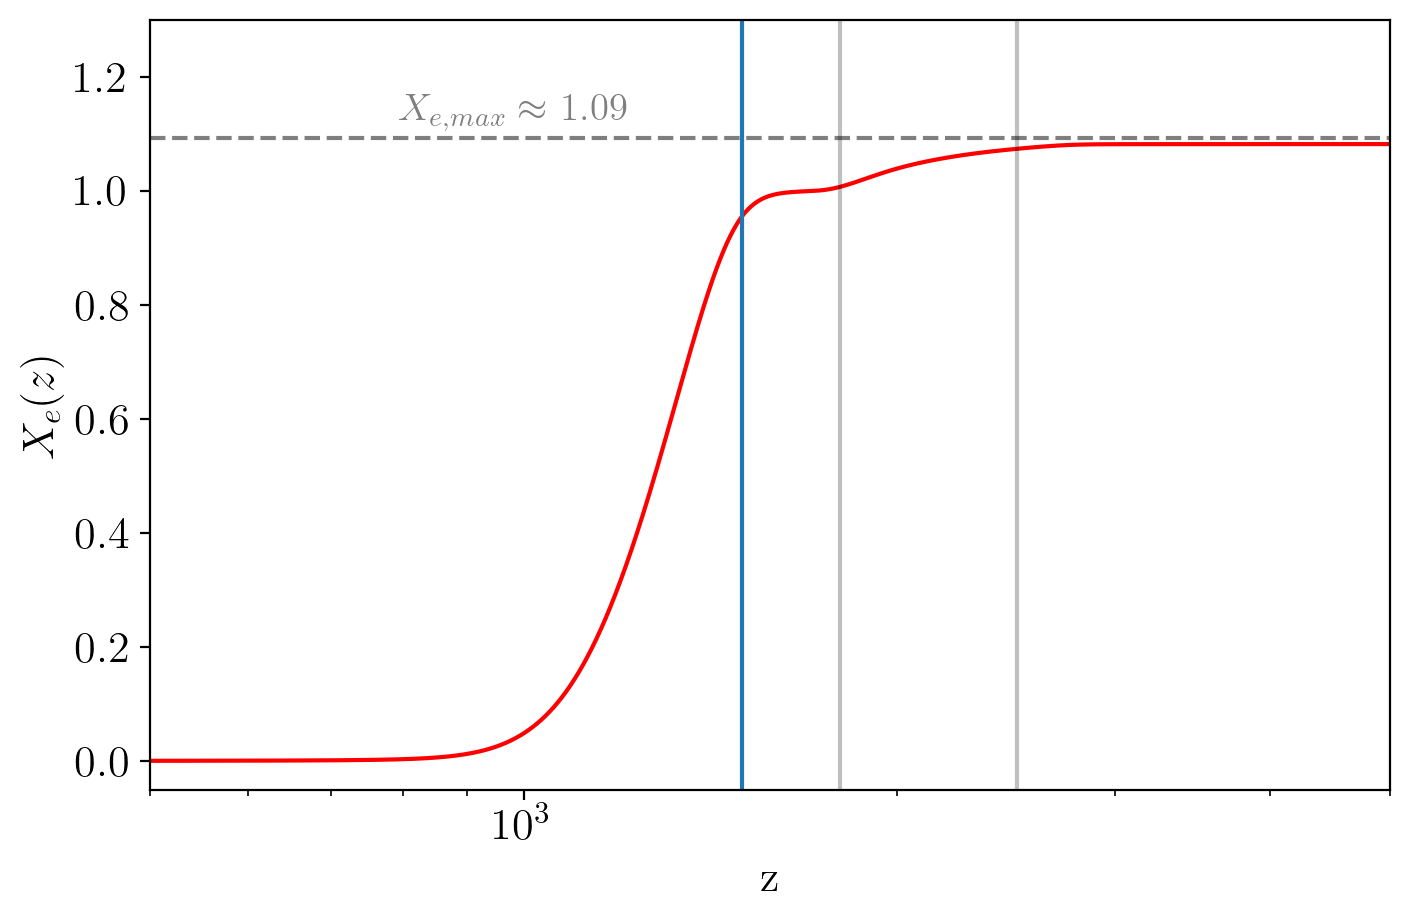

In [18]:
from scipy.interpolate import interp1d
fiducial_thermo = M.get_thermodynamics()
Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin
ll_max = 2500
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2
tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]

fiducial = fiducial_thermo["x_fid"]
fiducial_viz = fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"]
######################################################
######################################################

Yp = M.get_current_derived_parameters(['YHe'])['YHe']
xe_max = 1 + Yp/2*(1-Yp)

######################################################
# Plots
######################################################

fig,ax=plt.subplots(figsize=(8,5))

ax.plot(fiducial_thermo['z'], fiducial_thermo['x_e'], color='red')
ax.set_xlim([500, 5000])
ax.set_ylim([-0.05, 1.3])
ax.axhline([[xe_max]], linestyle="dashed", color="black", alpha=0.5)
ax.text(0.2, 0.87, "$X_{{e,max}} \\approx$ {:.2f}".format(xe_max), fontsize=14, transform=ax.transAxes, alpha=0.5)
ax.axvline([1800], color="black", alpha=0.25)

ax.axvline([2500], color="black", alpha=0.25)
ax.axvline([1500])

#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('z', fontsize=fsize)
ax.set_ylabel('$X_e(z)$', fontsize=fsize)

plt.show()
#plt.savefig("../results/standard_xe.pdf",dpi=300, bbox_inches='tight')

# Standard visibility function

Viz function has value 0.004236296412695108 at index 5687 and redshift 1221.115
0.20*viz_max = 0.004235378102007297
Viz function has value 0.0010519743824865175 at index 4881 and redshift 820.13
0.05*viz_max = 0.0010588445255018243
[ 820.          953.66666667 1087.33333333 1221.        ]


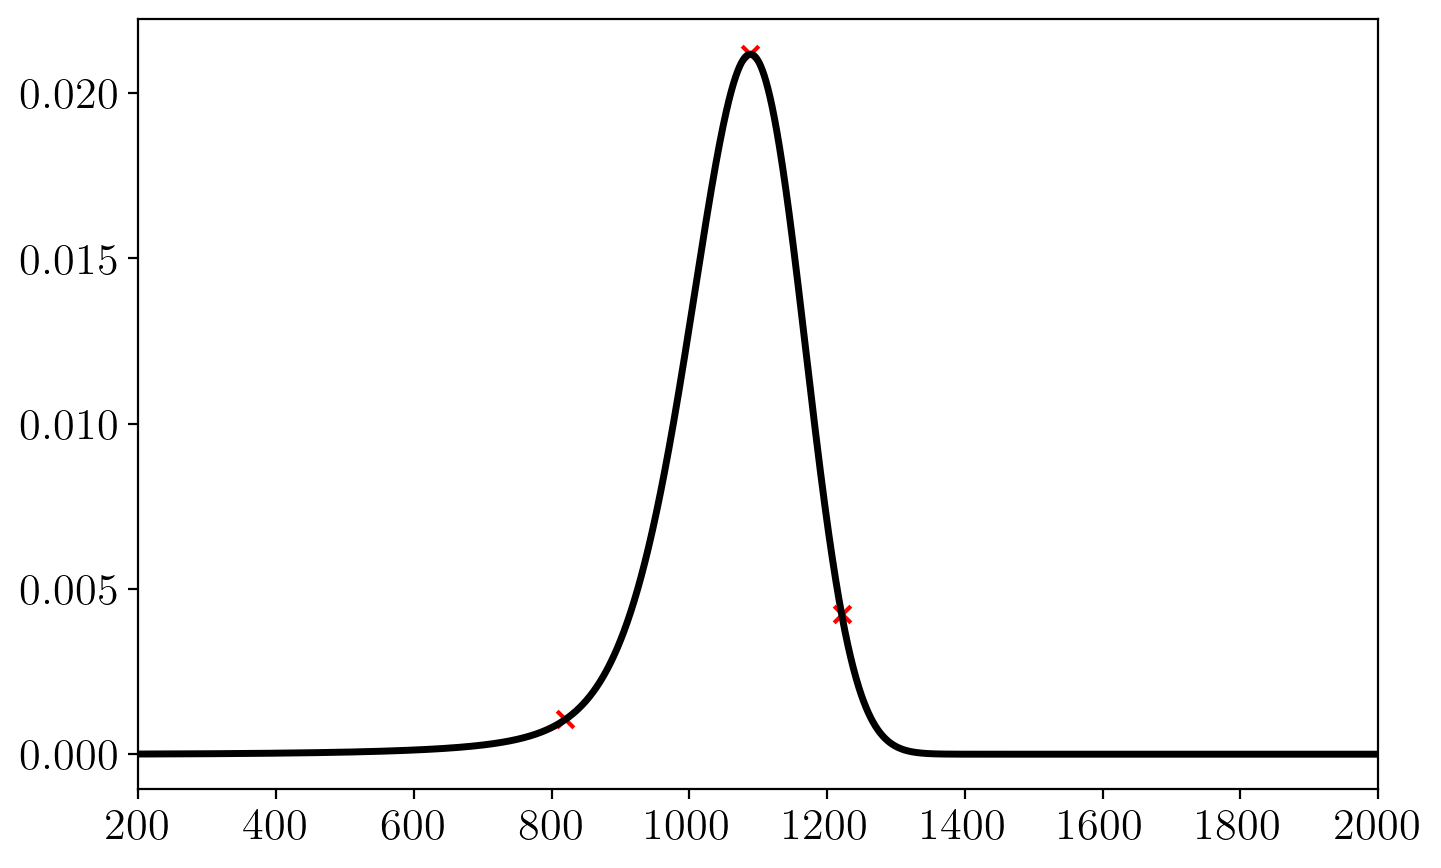

In [4]:
fig,ax = plt.subplots(figsize=(8,5))

ind_max = np.argmax(fiducial_viz)
max_viz = fiducial_viz[ind_max]

highz_percent_cutoff = 0.2
lowz_percent_cutoff = 0.05

test = np.where(fiducial_viz<highz_percent_cutoff*max_viz, 1, 0)
ind_highz = np.argwhere(np.diff(test)==1)[0][0]

test = np.where(fiducial_viz<lowz_percent_cutoff*max_viz, 1, 0)
ind_lowz = np.argwhere(np.diff(test)==-1)[0][0]

print("Viz function has value {0} at index {1} and redshift {2}".format(fiducial_viz[ind_highz], ind_highz, fiducial_thermo['z'][ind_highz]))
print("{0:.2f}*viz_max = {1}".format(highz_percent_cutoff, highz_percent_cutoff*max_viz))

print("Viz function has value {0} at index {1} and redshift {2}".format(fiducial_viz[ind_lowz], ind_lowz, fiducial_thermo['z'][ind_lowz]))
print("{0:.2f}*viz_max = {1}".format(lowz_percent_cutoff, lowz_percent_cutoff*max_viz))

control_redshifts = np.linspace(start=np.floor(fiducial_thermo['z'][ind_lowz]), stop=np.floor(fiducial_thermo['z'][ind_highz]), num=4)
print(control_redshifts)

ax.plot(fiducial_thermo['z'], fiducial_viz, linewidth=2.5, color="black")
ax.scatter(fiducial_thermo['z'][ind_max], fiducial_viz[ind_max], marker="x", color="red")
ax.scatter(fiducial_thermo['z'][ind_highz], fiducial_viz[ind_highz], marker="x", color="red")
ax.scatter(fiducial_thermo['z'][ind_lowz], fiducial_viz[ind_lowz], marker="x", color="red")
ax.set_xlim([200, 2000])
plt.show()

# Perturbing with control points

The maximum value that $X_e(x)$ can take on is about

$$
X_{e,max}(z) \approx 1 + \frac{Y_p}{2}(1-Y_p)
$$

where the excess above 1 comes from removing the electron in singly ionized Helium. We do not consider doubly ionized Helium as it recombines before the redshift ranges we are interested in. At any redshift, the perturbation to $X_e(z)$ must then fall between

$$
\Delta X_e(z) \in \left(-X_e(z), 1 + \frac{Y_p}{2}(1-Y_p) - X_e(z) \right)
$$

to ensure that the perturbed $X_e(z)$ is between $0$ and $X_{e,max}(z)$.

In [6]:
from scipy.interpolate import interp1d
import scipy
from scipy.optimize import fsolve

x_e = interp1d(fiducial_thermo["z"], fiducial_thermo["x_e"])

zmin_pert = 800
zmax_pert = 1400
zgrid = np.linspace(500, 1800, 200)
#zgrid = [zmin_pert, 1500, zmax_pert]

@np.vectorize
def rescale_pert_amp(amp, zz):
    shift = fsolve(lambda aa: scipy.special.expit(aa)*xe_max - x_e(zz), 0)
    return scipy.special.expit(amp+shift)*xe_max - x_e(zz)

print(fsolve(lambda aa: scipy.special.expit(aa)*xe_max - x_e(1000.), 0))
print(x_e(1000.0))
xgrid = np.linspace(-10, 10, 100)

delta_xe_upper = rescale_pert_amp(100, zgrid)
delta_xe_lower = rescale_pert_amp(-100, zgrid)
print(rescale_pert_amp(-6.464245903186192, 1300))

[-3.06578608]
0.0486646887978572
[-0.55944968]


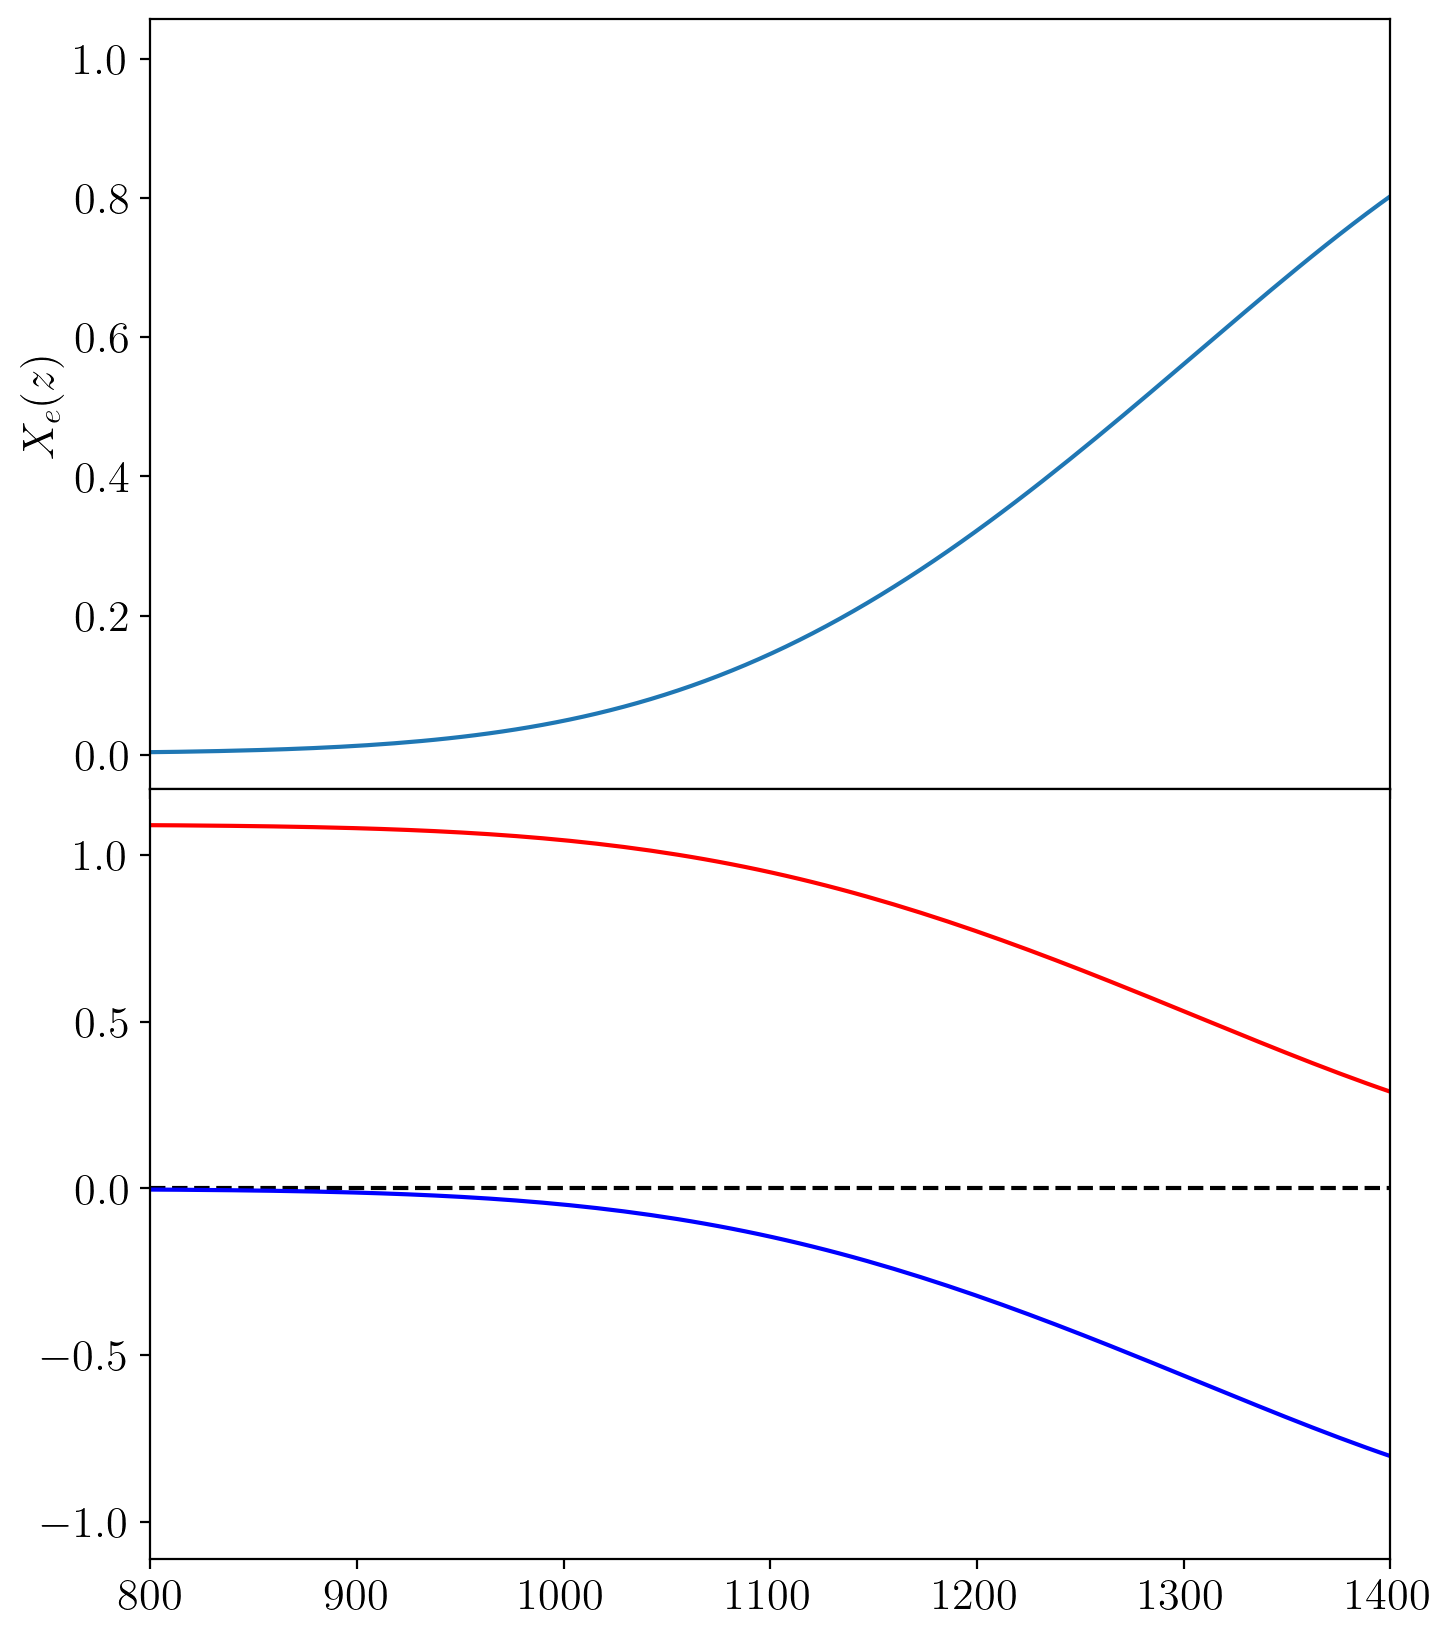

In [7]:
fig,ax=plt.subplots(2,1, sharex=True,  figsize=(8,10))

delta_xe_upper = rescale_pert_amp(100, zgrid)

plt.subplots_adjust(hspace=0)

ax[0].plot(zgrid, x_e(zgrid))
ax[0].set_xlim([zmin_pert, zmax_pert])
#ax[0].set_xscale('log')
ax[0].set_ylabel('$X_e(z)$', fontsize=fsize)

ax[1].plot(zgrid, delta_xe_upper, color="red")
ax[1].axhline(0.0, color="black", linestyle="dashed")
ax[1].plot(zgrid, delta_xe_lower, color="blue")
ax[1]

plt.show()

# Running with CLASS (single)


In [11]:
num_control_points = 5
#center_pivot = 1300
fine_grid = np.linspace(zmin_pert, zmax_pert, 100)

pivots = np.linspace(zmin_pert, zmax_pert, num_control_points+2, endpoint=True)
#pivots = np.array([zmin_pert, center_pivot, zmax_pert])
print(pivots)
free_pivots = pivots[1:-1]

#control_points = rescale_pert_amp(np.random.normal(loc=0.0, scale=2.0, size=4), free_pivots)
#control_points = np.random.normal(loc=0.0, scale=1.0, size=num_control_points)
control_points = np.random.normal(loc=0, scale=2, size=num_control_points)

control_points = np.insert(control_points, 0, 0.0)
control_points = np.append(control_points, 0.0)
str_pivots = ["{:.4f}".format(p) for p in pivots]
str_ctrl = ["{:.4f}".format(c) for c in control_points]
str_ctrl = "0.0,0.9155959817349935,-0.573647182297804,-2.996786701821708,-0.43581636934969303,-6.464245903186192,0.0"
#print(",".join(str_ctrl))
print(",".join(str_pivots))
print(zmin_pert)
print(zmax_pert)
print(len(pivots))

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["omega_b"],
                   'omega_cdm':standard_params["omega_cdm"],
                   'ln10^{10}A_s': standard_params["ln10^{10}A_s"],
                   'n_s':standard_params["n_s"],
                   #'tau_reio': standard_params["tau_reio"],
                   'reio_parametrization': 'reio_camb',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control',
                   'xe_pert_num': len(pivots),
                   'zmin_pert': zmin_pert,
                   'zmax_pert': zmax_pert,
                   #'xe_control_points': ",".join(str_ctrl),
                   'xe_control_points': str_ctrl,
                   'xe_control_pivots': ",".join(str_pivots)
                  }

precision_settings = {"start_sources_at_tau_c_over_tau_h": 0.004}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)

[ 800.  900. 1000. 1100. 1200. 1300. 1400.]
800.0000,900.0000,1000.0000,1100.0000,1200.0000,1300.0000,1400.0000
800
1400
7


True

In [12]:
M.compute(level=["thermodynamics"])

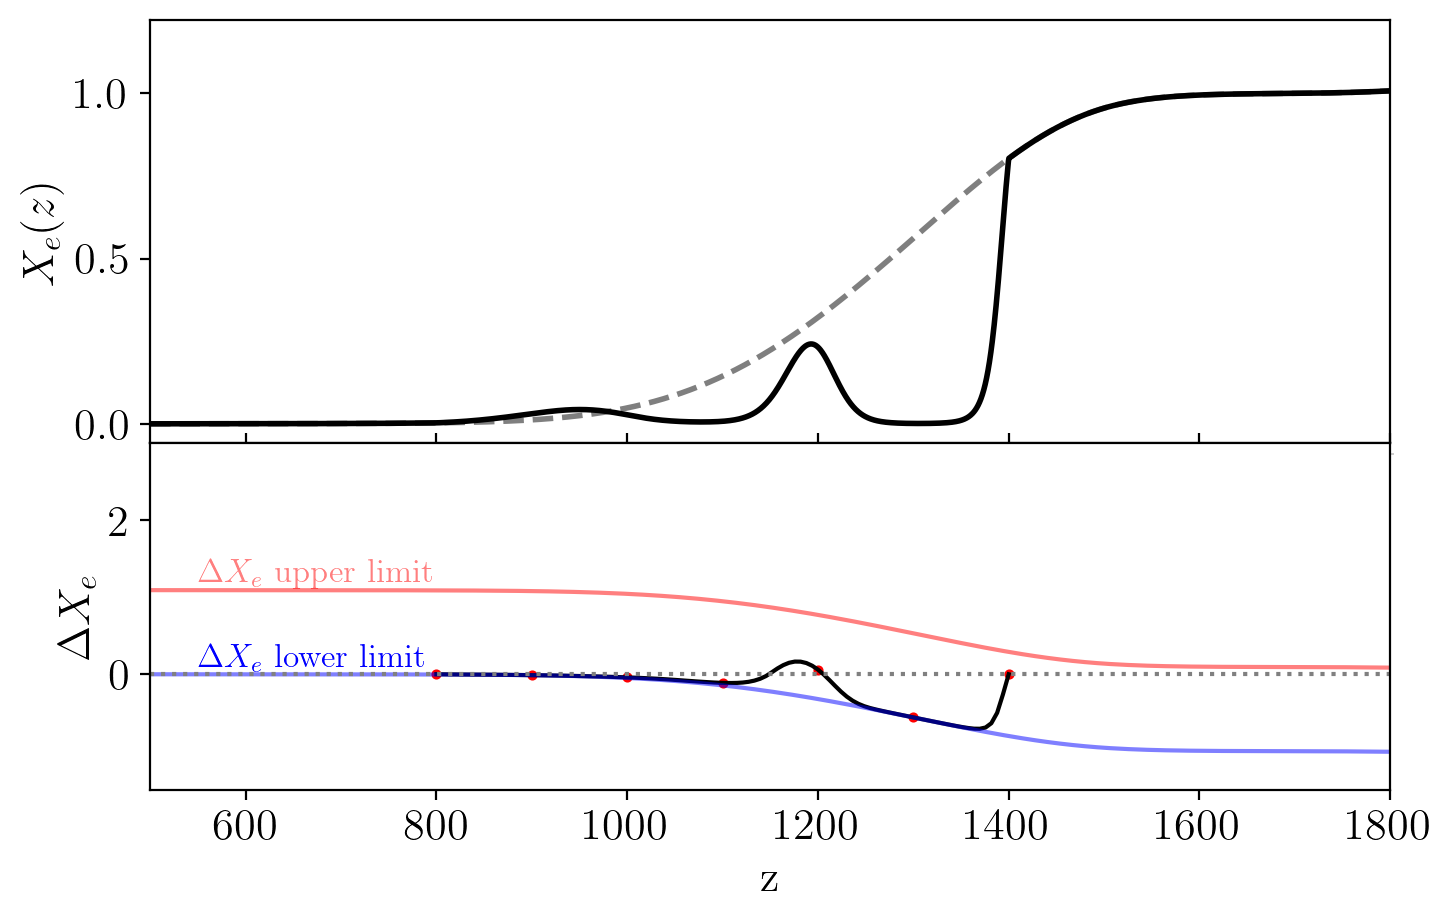

In [13]:
fig = plt.figure(figsize=(8, 5))
main_axis_ratio = .55
residual_axis_ratio = 0.45
grid = plt.GridSpec(2, 1, height_ratios=[main_axis_ratio, residual_axis_ratio],hspace=0.0)

main_ax = fig.add_subplot(grid[0])
res_ax = fig.add_subplot(grid[1],sharex=main_ax)

thermo = M.get_thermodynamics()
class_perturbation = thermo["xe_pert"]
class_z = thermo["z"]

main_ax.plot(class_z, thermo["x_fid"], color="black", linestyle="dashed", linewidth=2, alpha=0.5)
main_ax.plot(class_z, thermo["x_e"], color="black", linewidth=2)
main_ax.set_ylabel("$X_e(z)$")
main_ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 0)

res_ax.scatter(pivots, rescale_pert_amp(control_points,pivots), s=7, color="red")
#res_ax.scatter(pivots, control_points, color="red", s=7, alpha=1)
#res_ax.plot(fine_grid, interp1d(pivots, control_points, kind='cubic')(fine_grid), color="black", linestyle='solid', alpha=0.5)
res_ax.plot(fine_grid, rescale_pert_amp(interp1d(pivots, control_points, kind='quadratic')(fine_grid), fine_grid), color="black")
#ax.plot(class_z, class_perturbation, linewidth=2, color="orange", linestyle="dashed")
res_ax.set_xlabel("z", fontsize=fsize)
res_ax.set_ylabel("$\Delta X_e$", fontsize=fsize)
res_ax.plot(zgrid, delta_xe_upper, color="red", alpha=0.5)
#ax.axhline(0.0, color="black", linestyle="dashed")
res_ax.plot(zgrid, delta_xe_lower, color="blue", alpha=0.5)

res_ax.text(550, 1.2, "$\Delta X_e$ upper limit", color="red", alpha=0.5, fontsize=12)
res_ax.text(550, 0.1, "$\Delta X_e$ lower limit", color="blue", fontsize=12)

res_ax.set_xlim([500, 1800])
res_ax.set_ylim([-1.5, 3])
res_ax.axhline(0.0, linestyle="dotted", color="gray")
#plt.legend()
#plt.show()
plt.savefig("../results/delta_xe_3.png",dpi=300, bbox_inches='tight')

In [35]:
@np.vectorize
def rescale_pert_amp(amp, zz):
    shift = fsolve(lambda aa: scipy.special.expit(aa)*xe_max - x_e(zz), 0)
    return scipy.special.expit(amp+shift)*xe_max - x_e(zz)

def inverse_scaling(scaled_amp, zz):
    shift = fsolve(lambda aa: scipy.special.expit(aa)*xe_max - x_e(zz), 0)
    return scipy.special.logit((scaled_amp+x_e(zz))/(xe_max)) - shift

amp = 1.5
ztest = 1100

sa = rescale_pert_amp(amp, ztest)[0]
print(inverse_scaling(sa, ztest))

[1.5]


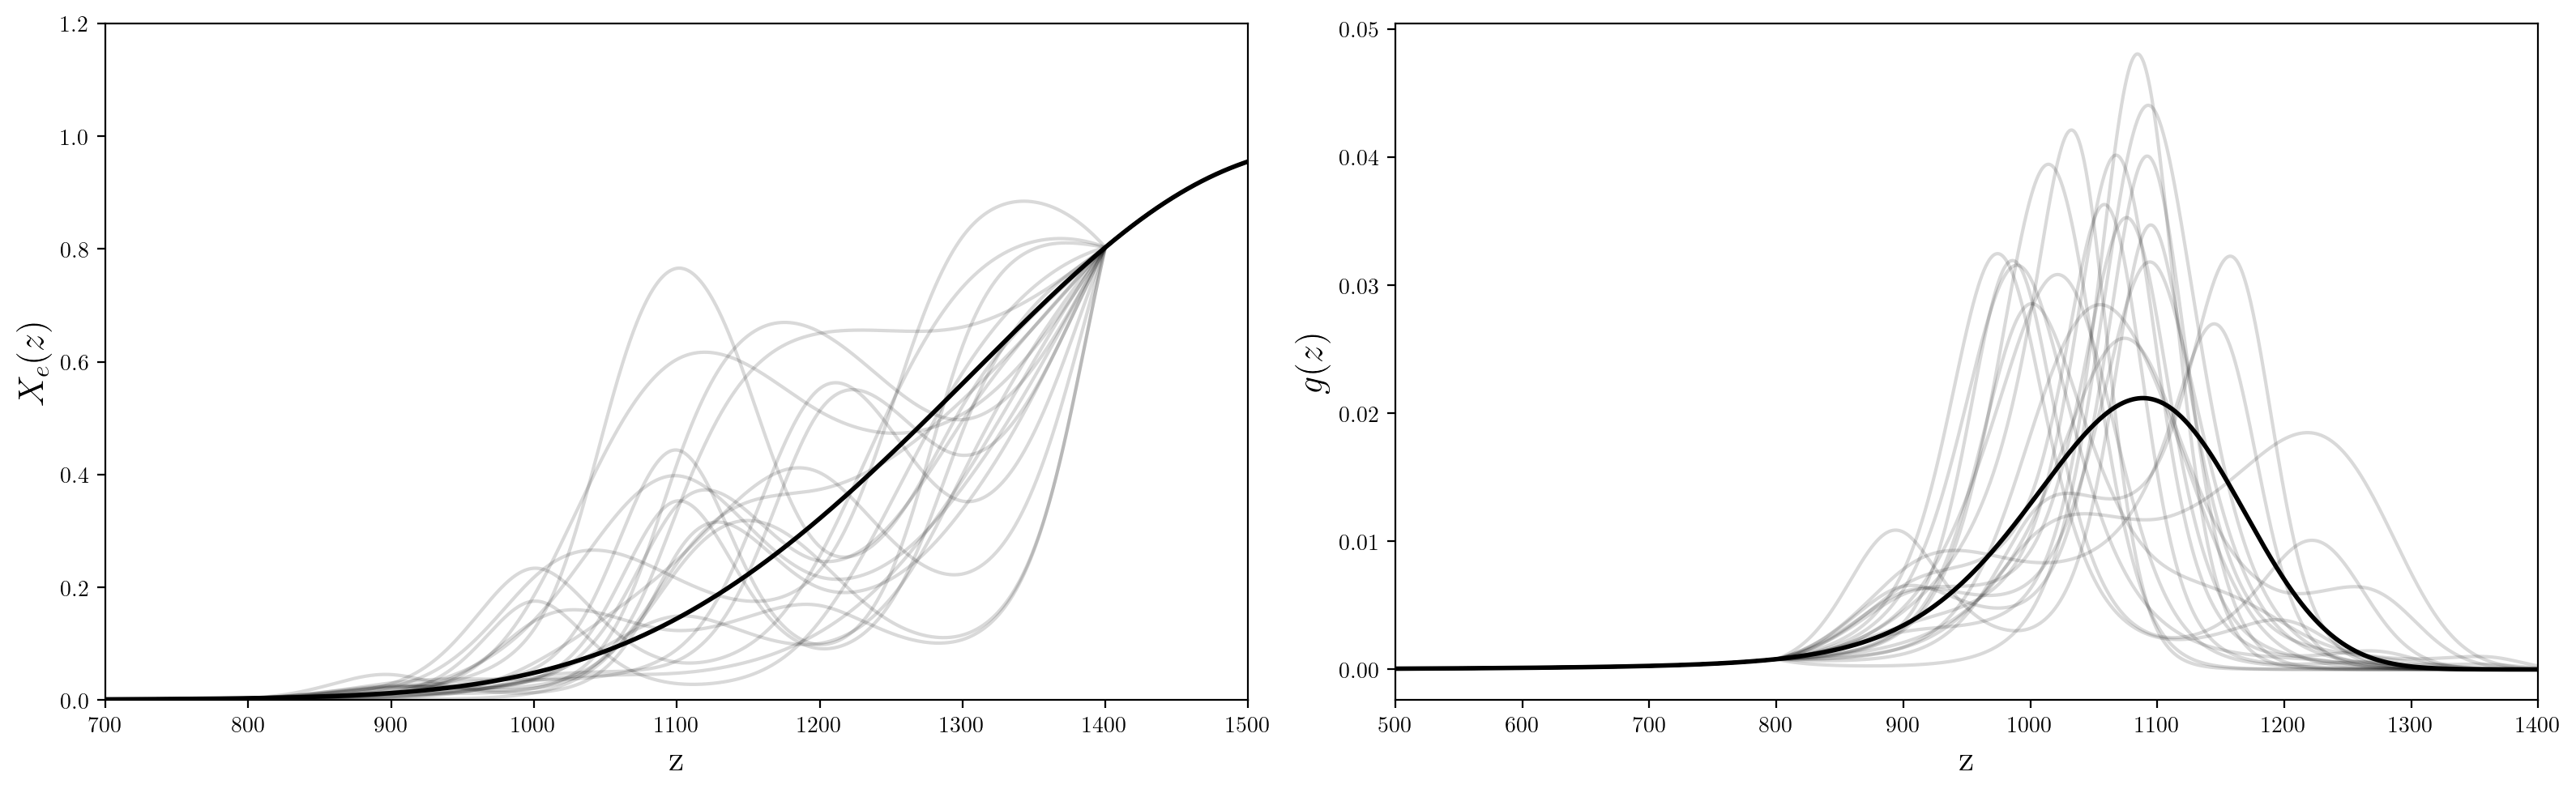

In [43]:
num_of_functions = 20

fig,ax=plt.subplots(1, 2, figsize=(16,5))
plt.subplots_adjust(hspace=0.0)

#ax.text(0.2, 0.65, "$X_{{e,max}} \\approx$ {:.2f}".format(xe_max), fontsize=14, transform=ax.transAxes, alpha=0.5)
#ax.set_xscale('log')
ax[1].set_xlabel('z', fontsize=fsize)
ax[0].set_xlabel('z', fontsize=fsize)

ax[0].set_ylabel('$X_e(z)$', fontsize=fsize)
ax[1].set_ylabel('$g(z)$', fontsize=fsize)


def get_uniform_cps(free_pivots):
    outlist = []
    for z in free_pivots:
        ul = interp1d(zgrid, delta_xe_upper)(z)
        ll = interp1d(zgrid, delta_xe_lower)(z)
        scaled_amp = np.random.uniform(low = ll, high=ul)
        outlist.append(inverse_scaling(scaled_amp, z)[0])
    return np.array(outlist)

cltts = []
xes = []
gs = []

ll_max = 2500
ll = np.arange(2, ll_max+1)

for i in np.arange(num_of_functions):
    #control_points = get_uniform_cps(free_pivots)
    control_points = np.random.normal(loc=0, scale=1, size=len(free_pivots))
    control_points = np.insert(control_points, 0, 0.0)
    control_points = np.append(control_points, 0.0)
    str_ctrl = [str(c) for c in control_points]
    #print("xe_control_points: '{}'".format(",".join(str_ctrl)))
    M.set({"xe_control_points": ",".join(str_ctrl)})
    M.compute()
    thermo = M.get_thermodynamics()
    ax[0].plot(thermo['z'], thermo["x_fid"]+thermo['xe_pert'], color="black", alpha=0.15)
    ax[1].plot(thermo['z'], thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"], color="black", alpha=0.15)
    Tcmb = M.T_cmb()*10**6 
    muK2 = (Tcmb)**2
    tt = muK2*M.lensed_cl(ll_max)['tt'][2:]
    cltts.append(ll*(ll+1)/(2*np.pi)*tt)
   
ax[0].plot(fiducial_thermo["z"], fiducial_thermo["x_e"], color="black", linewidth=2)
#ax[0].plot(ll,  ll*(ll+1)/(2*np.pi)*tt_fid, color="red")
ax[0].set_xlim([zmin_pert-100, zmax_pert+100])
ax[0].set_ylim([0, 1.2])
ax[1].plot(fiducial_thermo["z"], fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"], color="black", linewidth=2)
ax[1].set_xlim([500, 1400])
#ax[0].set_xlim([zmin_pert, 2000])
#ax[0].set_ylim([0, 1.3])
plt.tight_layout()
plt.savefig("../results/control_point_talk.png",dpi=300, bbox_inches='tight')
plt.show()

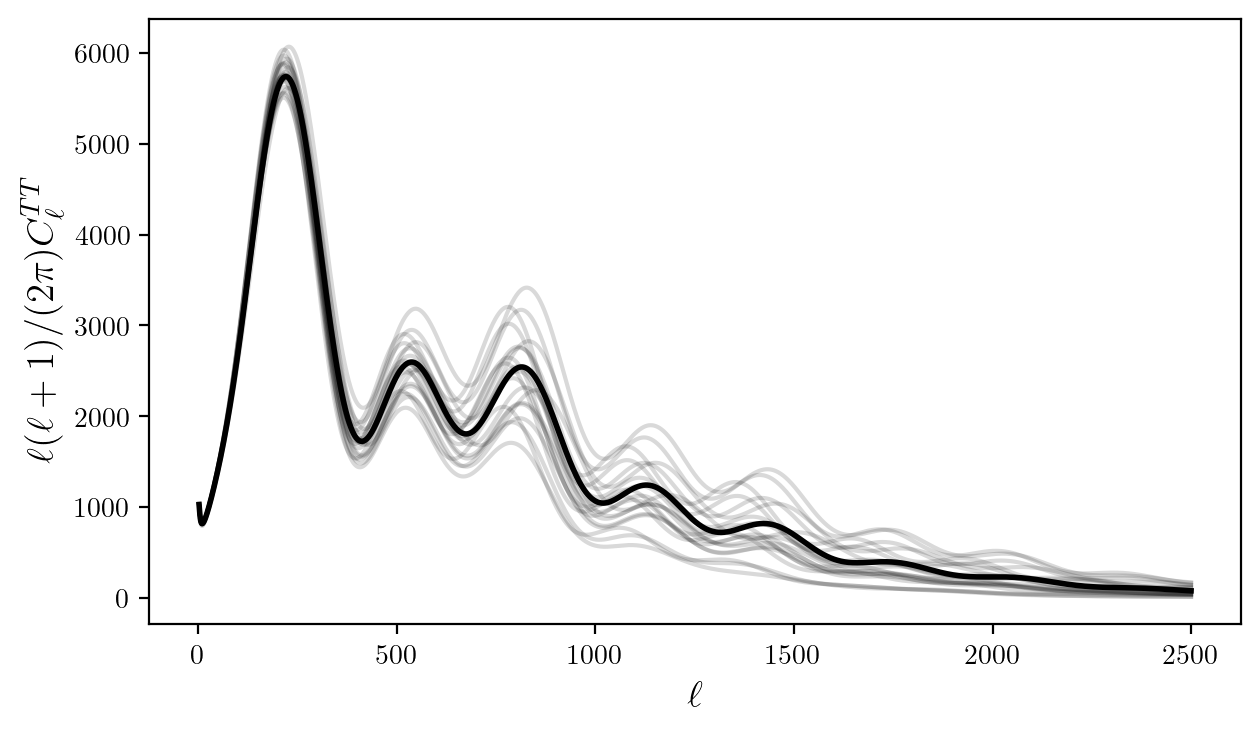

In [46]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 10,
    'text.usetex': True,
    'pgf.rcfonts': False,
})
fig,ax = plt.subplots()
fig.set_size_inches(w=7.04, h=3.93)

for Dltt in cltts:
    ax.plot(ll, Dltt, alpha=0.15, color="black")

ax.plot(ll, ll*(ll+1)/(2*np.pi)*tt_fid, linewidth=2, color="black")
ax.set_xlabel("$\ell$", fontsize=14)
ax.set_ylabel("$\ell (\ell +1) / (2\pi) C_\ell^{TT}$", fontsize=14)
plt.savefig("../results/dltt_variations_example.png",dpi=300, bbox_inches='tight')


In [89]:
new_settings = {"ln10^{10}A_s": ln10e10As,
                'n_s': standard_params["n_s"],
                'H0': standard_params["H0"], 
                #'100*theta_s': 1.0419204993632236, 
                'omega_b': standard_params["omega_b"], 
                'omega_cdm': standard_params["omega_cdm"], 
                'tau_reio': standard_params["tau_reio"],
                'reio_parametrization': 'reio_camb',
                'xe_control_points': '0.0,-0.12810783285357646,0.06545464970290647,0.2656826392480541,-0.2599179882176763,0.0',
                'xe_pert_type': 'control', 
                'lensing': 'yes', 
                'zmin_pert': 500 ,
                'xe_pert_num': 6, 
                'zmax_pert': 1400, 
                'xe_control_pivots': '500.0000,680.0000,860.0000,1040.0000,1220.0000,1400.0000', 
                'output': 'tCl,pCl,lCl'}

print(",".join(str_ctrl))
print(",".join(str_pivots))

precision_settings = {"start_sources_at_tau_c_over_tau_h": 0.004}

M = Class.Class()
M.set(new_settings)
M.set(precision_settings)

print(rescale_pert_amp(control_points, pivots))

0.0,-0.19938432778091308,-0.4946485652915702,-0.2566196108629947,0.02873110725638082,-0.8328726466737352,0.35520000994524664,-0.0003429363046450447,-0.22990435924323438,0.7259278317577108,0.15632879493242996,0.0
500.0000,590.9091,681.8182,772.7273,863.6364,954.5455,1045.4545,1136.3636,1227.2727,1318.1818,1409.0909,1500.0000
[ 2.79724161e-17 -1.67700340e-04 -5.51235076e-04 -6.13169926e-04
  2.22812068e-04 -1.50991776e-02  3.16313169e-02 -5.59652369e-05
 -5.50303543e-02  1.80625699e-01  3.05897380e-02 -4.10782519e-15]


In [ ]:
M.compute()

In [ ]:
thermo = M.get_thermodynamics()
params = M.get_current_derived_parameters(['tau_reio'])
print(thermo.keys())
print(params)

pivots = np.array([500.,680.,860.,1040.,1220.,1400.])
cp = np.zeros(shape=6)

inter = interp1d(pivots, cp, kind="cubic")
fine = np.linspace(500, 1400, 100)

zz_array = thermo["z"]
x_fid = thermo["x_fid"]
xe_pert = thermo["xe_pert"]
xe_total = thermo["x_e"]

fig, ax=plt.subplots()

ax.plot(zz_array, x_fid+xe_pert, color="black", label="fid+pert")
ax.plot(zz_array, x_fid, color="blue", linestyle="dotted", label="x_fid")
ax.plot(zz_array, xe_pert, color="green")
ax.plot(zz_array, xe_total, color="red", linestyle="dashed", label="x_e")
ax.plot(fine, inter(fine))
ax.axvline(1400)
ax.set_xlim([1.3, 2500])
ax.set_xscale('log')
plt.legend()

plt.show()

In [ ]:
redshift = 1100

a1 = np.linspace(-10, 10, 100)
z1 = np.full(a1.shape, redshift)
r1 = rescale_pert_amp(a1, z1)

a2 = np.linspace(-1, 1, 5)
z2 = np.full(a2.shape, redshift)
r2 = rescale_pert_amp(a2, z2)

print(a2)
print(r2)

fig,ax=plt.subplots()

#ax.plot(amplitudes, amplitudes, color="black")
ax.plot(a1, r1, color="red")
ax.scatter(a2, r2, s=4)
plt.show()

In [ ]:
float_list = np.linspace(500,1400, 6)
string_list = ["{:.2f}".format(f) for f in float_list]
perturbations = np.linspace(-1, 1, 5)
string = ",".join(string_list)
print(string)

for f in float_list:
    print("Trial values for redshift {}".format(f))
    trial_values = []
    ind = 0
    for i,val in enumerate(string.split(",")):
        if float(val)==f:
            ind=i
    temp_arr = np.zeros(float_list.shape)
    for p in perturbations:
        temp_arr[ind] = p
        temp_arr_str = ["{:.2f}".format(q) for q in temp_arr]
        trial_values.append(",".join(temp_arr_str))
    for s in trial_values:
        print(s)

        



In [ ]:
test = np.arange(20)
l_min = 10
ll = test[2:]
print(test[:6])
print(ll)
ll[:(l_min-2)]*=[0]
print(ll)

In [ ]:
a = {"cow": "moo", "pig": "oink"}

b = 'git push'

np.savez('file', a=a,comment=b)

data = np.load('file.npz', allow_pickle=True)["comment"]
print(type(str(data)))

In [ ]:
arr = ["a", "b", "c"]
arr.remove("c")
print(arr)

In [ ]:
test_cp = np.random.normal(loc=0.0, scale=0.25, size=10000)

rescaled_cp = rescale_pert_amp(test_cp, 800)

fig,ax=plt.subplots()

ax.hist(test_cp, bins="fd", density=True)
ax.hist(rescaled_cp, bins="fd", density=True)
ax.set_xlim([-1,1])
ax.set_ylim([0,2])
plt.show()

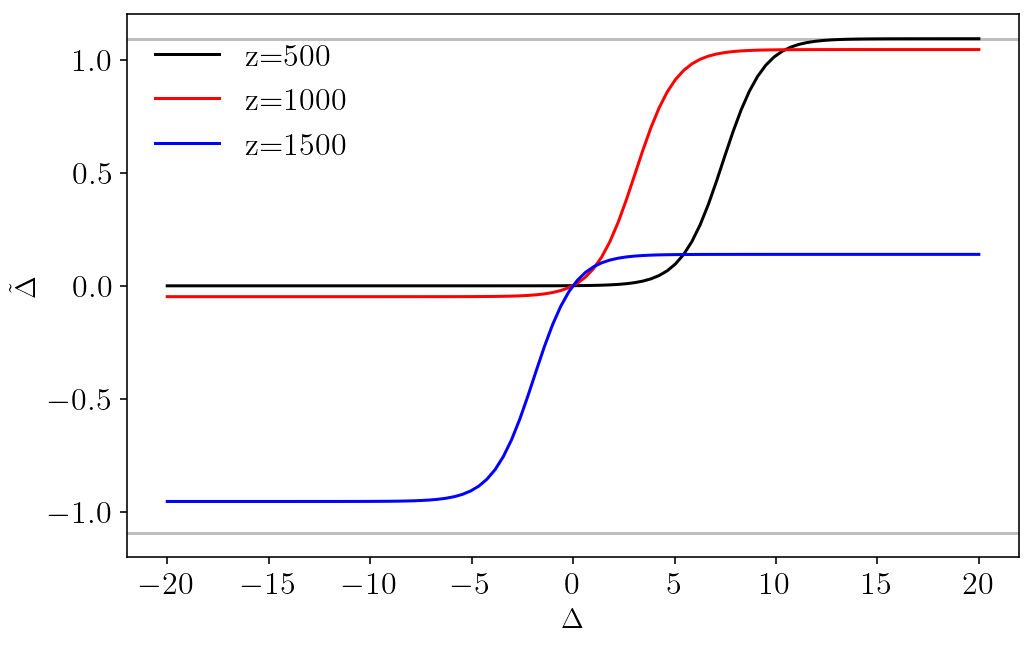

In [103]:
zlist = [500, 1000, 1500]
amp_grid = np.linspace(-20, 20, 100)

fig,ax=plt.subplots(figsize=(8,5))

ax.plot(amp_grid, rescale_pert_amp(amp_grid, zlist[0]), label="z={}".format(zlist[0]), color="black")
ax.plot(amp_grid, rescale_pert_amp(amp_grid, zlist[1]), label="z={}".format(zlist[1]), color="red")
ax.plot(amp_grid, rescale_pert_amp(amp_grid, zlist[2]), label="z={}".format(zlist[2]), color="blue")

ax.set_xlabel("$\Delta$", fontsize=14)
ax.set_ylabel("$\\tilde{\Delta}$", fontsize=14)
ax.axhline(xe_max, color="black", alpha=0.25)
ax.axhline(-xe_max, color="black", alpha=0.25)

plt.legend(frameon=False)


plt.savefig("../results/rescaling_examples.jpg",dpi=300, bbox_inches='tight')
plt.show()

[1.09259 1.09259 1.09259 ... 1.09259 1.09259 1.09259]


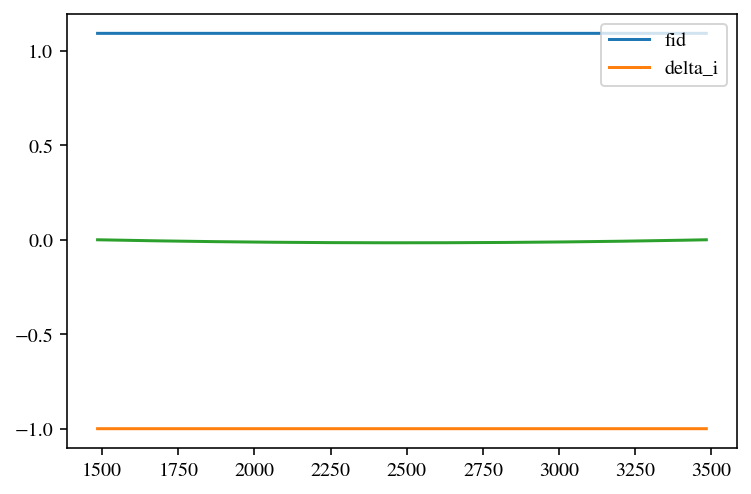

In [11]:
test = np.loadtxt("example1.txt")
print(test[:,0])
zz=np.where(np.logical_and(class_z>zmin_pert, class_z<zmax_pert))[0]
fig,ax=plt.subplots()
ax.plot(zz, test[:,0], label="fid")
ax.plot(zz, test[:,1], label="delta_i")
ax.plot(zz, -test[:,3])
plt.legend()